## Density decomposition
Motivation: Need an unambiguous density decomposition stating which density belongs to which atom.

Idea: Use alchemy to grow a molecule from original locations far away.
$$\rho_t -\rho_r= \int_r^t d\lambda \partial_\lambda\rho = \int_r^t d\lambda \sum_I \frac{\partial\rho}{\partial Z_I}\frac{\partial Z_I}{\partial\lambda}=  \sum_I \Delta Z_I\int_r^t d\lambda\frac{\partial\rho}{\partial Z_I}$$

In [13]:
import horton
import numpy as np
import matplotlib.pyplot as plt

## Diatomics

In [221]:
def do_run(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints):
    pseudo = np.array(pseudo)*1.0
    print (pseudo)
    refdist, targetdist = float(refdist), float(targetdist)
    mol = horton.IOData(title='test')
    mol.coordinates = np.array([[0.0, 0.0, -refdist/2.], [0.0, 0.0, -targetdist/2.], [0.0, 0.0, targetdist/2.], [0.0, 0.0, refdist/2.]]) * horton.angstrom
    mol.numbers = np.array([z1, z1, z2, z2])
    mol.pseudo_numbers = pseudo
    
    basisset = 'STO-3G'
    #basisset='6-31G(d)'
    #basisset = 'def2-TZVP'
    obasis = horton.get_gobasis(mol.coordinates, mol.numbers, basisset)
    for z in zsuper:
        obasis2 = horton.get_gobasis(mol.coordinates, np.array([z]*4), basisset)
        obasis = obasis.concatenate(obasis2)
    
    olp = obasis.compute_overlap()
    kin = obasis.compute_kinetic()
    na = obasis.compute_nuclear_attraction(mol.coordinates, mol.pseudo_numbers)
    er = obasis.compute_electron_repulsion()
    
    orb_alpha = horton.Orbitals(obasis.nbasis)
    orb_beta = horton.Orbitals(obasis.nbasis)

    # Initial guess
    one = kin + na
    horton.guess_core_hamiltonian(olp, one, orb_alpha, orb_beta)
    
    external = {'nn': horton.compute_nucnuc(mol.coordinates, mol.pseudo_numbers)}
    terms = [
        horton.UTwoIndexTerm(kin, 'kin'),
        horton.UDirectTerm(er, 'hartree'),
        horton.UExchangeTerm(er, 'x_hf'),
        horton.UTwoIndexTerm(na, 'ne'),
    ]
    ham = horton.UEffHam(terms, external)
    
    #LDA
    #grid = horton.BeckeMolGrid(mol.coordinates, mol.numbers, mol.numbers, 'fine', mode='keep', random_rotate=False)
    #terms = [
    #    horton.UTwoIndexTerm(kin, 'kin'),
    #    horton.UGridGroup(obasis, grid, [
    #        horton.UBeckeHartree(lmax=8),
    #        horton.ULibXCLDA('x'),
    #        horton.ULibXCLDA('c_vwn'),
    #    ]),
    #    horton.UTwoIndexTerm(na, 'ne'),
    #]
    #ham = horton.UEffHam(terms, external)
    
    #PBE
    #terms = [
    #    horton.UTwoIndexTerm(kin, 'kin'),
    #    horton.UDirectTerm(er, 'hartree'),
    #    horton.UGridGroup(obasis, grid, [
    #        horton.ULibXCGGA('x_pbe'),
    #        horton.ULibXCGGA('c_pbe'),
    #    ]),
    #    horton.UTwoIndexTerm(na, 'ne'),
    #]
    #ham = horton.UEffHam(terms, external)
    
    
    converged = False
    for solver in (horton.CDIISSCFSolver, horton.EDIIS2SCFSolver,horton.ODASCFSolver,  horton.EDIISSCFSolver, ):
        try:
            occ_model = horton.AufbauOccModel(7, 7)
        
            occ_model.assign(orb_alpha, orb_beta)
            dm_alpha = orb_alpha.to_dm()
            dm_beta = orb_beta.to_dm()
            scf_solver = solver(1e-5, maxiter=100)
            scf_solver(ham, olp, occ_model, dm_alpha, dm_beta)
            converged = True
        except:
            continue
    if not converged:
        raise horton.NoSCFConvergence('no conv')
    
    rho_grid = obasis.compute_grid_density_dm(dm_alpha, gridpoints)
    rho_grid += obasis.compute_grid_density_dm(dm_beta, gridpoints)
    
    return rho_grid
def get_partial_derivative(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints, site):
    pseudo = np.array(pseudo)
    
    delta = 0.05
    if pseudo[site] - delta/2. < 0:
        # forward finite differences only
        rho = do_run(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints)    
        
        pseudonew = pseudo.copy()
        pseudonew[site] += delta
        rhoup = do_run(refdist, targetdist, pseudonew, z1, z2, zsuper, gridpoints)
        
        deriv = (rhoup - rho) / delta
    else:
        # central FD
        pseudonew = pseudo.copy()
        pseudonew[site] += delta/2.
        rhoup = do_run(refdist, targetdist, pseudonew, z1, z2, zsuper, gridpoints)
        
        pseudonew = pseudo.copy()
        pseudonew[site] -= delta/2.
        rhodn = do_run(refdist, targetdist, pseudonew, z1, z2, zsuper, gridpoints)
        
        deriv = (rhoup - rhodn)/delta
    return deriv

### Test cases

[7. 0. 0. 7.]
[7. 0. 0. 7.]
[7. 0. 0. 7.]
[6.3 0.7 0.7 6.3]
[5.6 1.4 1.4 5.6]
[4.9 2.1 2.1 4.9]
[4.2 2.8 2.8 4.2]
[3.5 3.5 3.5 3.5]
[2.8 4.2 4.2 2.8]
[2.1 4.9 4.9 2.1]
[1.4 5.6 5.6 1.4]
[0.7 6.3 6.3 0.7]
[0. 7. 7. 0.]


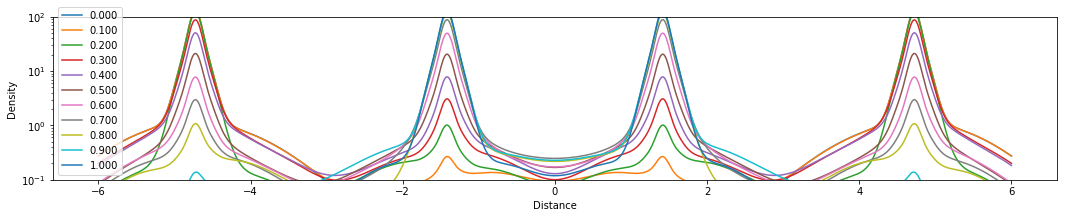

In [80]:
def test_invariant_target_distance():
    refdist, targetdist = 10, 1.5
    pseudo = (7, 0, 0, 7)
    z1, z2, zsuper = 7, 7, []
    zs = np.linspace(-20, 20, 100)
    xs = zs * 0
    gridpoints = np.vstack((xs, xs, zs)).T.copy()
    rhoA = do_run(refdist, targetdist, pseudo, z1, z2, zsuper, gridpoints)
    rhoB = do_run(refdist, targetdist*2, pseudo, z1, z2, zsuper, gridpoints)
    assert max(np.abs(rhoA-rhoB)) / np.max(abs(rhoA)) < 1e-5
test_invariant_target_distance()
def test_spacing_density():
    plt.figure(figsize=(18,3))
    refdist, targetdist = 5, 1.5
    pseudo = np.array((7, 0, 0, 7))
    deltaZ = np.array((-7., 7., 7., -7.))
    z1, z2, zsuper = 7, 7, []
    zs = np.linspace(-6, 6, 1000)
    xs = zs * 0
    gridpoints = np.vstack((xs, xs, zs)).T.copy()
    for lval in np.linspace(0, 1, 11):
        rho = do_run(refdist, targetdist, pseudo + lval*deltaZ, z1, z2, zsuper, gridpoints)
        plt.semilogy(zs, rho, label='%5.3f' %lval)
    plt.ylim(1e-1, 100)
    plt.legend()
    plt.xlabel('Distance')
    plt.ylabel('Density')
test_spacing_density()

[7. 0. 0. 7.]
[6.3 0.7 0.7 6.3]
[6.125 0.875 0.875 6.125]
[6.475 0.525 0.525 6.475]
[5.6 1.4 1.4 5.6]
[5.425 1.575 1.575 5.425]
[5.775 1.225 1.225 5.775]
[4.9 2.1 2.1 4.9]
[4.725 2.275 2.275 4.725]
[5.075 1.925 1.925 5.075]
[4.2 2.8 2.8 4.2]
[4.025 2.975 2.975 4.025]
[4.375 2.625 2.625 4.375]
[3.5 3.5 3.5 3.5]
[3.325 3.675 3.675 3.325]
[3.675 3.325 3.325 3.675]
[2.8 4.2 4.2 2.8]
[2.625 4.375 4.375 2.625]
[2.975 4.025 4.025 2.975]
[2.1 4.9 4.9 2.1]
[1.925 5.075 5.075 1.925]
[2.275 4.725 4.725 2.275]
[1.4 5.6 5.6 1.4]
[1.225 5.775 5.775 1.225]
[1.575 5.425 5.425 1.575]
[0.7 6.3 6.3 0.7]
[0.525 6.475 6.475 0.525]
[0.875 6.125 6.125 0.875]
[0. 7. 7. 0.]


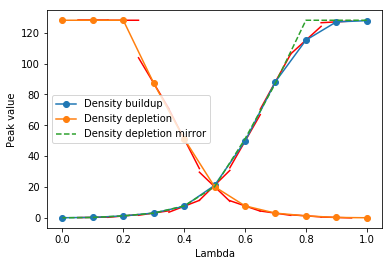

In [121]:
def test_whole_derivative():
    refdist, targetdist = 13.5, 1.5
    pseudo = np.array((7, 0, 0, 7))
    deltaZ = np.array((-7., 7., 7., -7.))
    z1, z2, zsuper = 7, 7, []
    zs = np.array([refdist*horton.angstrom/2, targetdist*horton.angstrom/2])
    xs = zs * 0
    gridpoints = np.vstack((xs, xs, zs)).T.copy()
    rhos = []
    lvals = np.linspace(0, 1, 11)
    plotspan = (lvals[1] - lvals[0])/2
    delta = 0.05
    for lval in lvals:
        rho = do_run(refdist, targetdist, pseudo + lval*deltaZ, z1, z2, zsuper, gridpoints)
        rhos.append(rho)
        if lval not in (0, 1):
            rhoup = do_run(refdist, targetdist, pseudo + (lval+delta/2)*deltaZ, z1, z2, zsuper, gridpoints)
            rhodn = do_run(refdist, targetdist, pseudo + (lval-delta/2)*deltaZ, z1, z2, zsuper, gridpoints)
            deriv = (rhoup - rhodn)/delta
            
            for point in (0, 1):
                plt.plot((lval-plotspan, lval+plotspan), (rho[point]-deriv[point]*plotspan, rho[point]+deriv[point]*plotspan), color='red')
    rhos = np.array(rhos)
    plt.plot(lvals, rhos[:, 1], 'o-', label='Density buildup')
    plt.plot(lvals, rhos[:, 0], 'o-', label='Density depletion')
    plt.plot(1-lvals, rhos[:, 0], '--', label='Density depletion mirror')
    plt.legend()
    plt.ylabel('Peak value')
    plt.xlabel('Lambda')
test_whole_derivative()

[7.025 0.    0.    7.   ]
[6.975 0.    0.    7.   ]
[6.675 0.35  0.35  6.65 ]
[6.625 0.35  0.35  6.65 ]
[6.325 0.7   0.7   6.3  ]
[6.275 0.7   0.7   6.3  ]
[5.975 1.05  1.05  5.95 ]
[5.925 1.05  1.05  5.95 ]
[5.625 1.4   1.4   5.6  ]
[5.575 1.4   1.4   5.6  ]
[5.275 1.75  1.75  5.25 ]
[5.225 1.75  1.75  5.25 ]
[4.925 2.1   2.1   4.9  ]
[4.875 2.1   2.1   4.9  ]
[4.575 2.45  2.45  4.55 ]
[4.525 2.45  2.45  4.55 ]
[4.225 2.8   2.8   4.2  ]
[4.175 2.8   2.8   4.2  ]
[3.875 3.15  3.15  3.85 ]
[3.825 3.15  3.15  3.85 ]
[3.525 3.5   3.5   3.5  ]
[3.475 3.5   3.5   3.5  ]
[3.175 3.85  3.85  3.15 ]
[3.125 3.85  3.85  3.15 ]
[2.825 4.2   4.2   2.8  ]
[2.775 4.2   4.2   2.8  ]
[2.475 4.55  4.55  2.45 ]
[2.425 4.55  4.55  2.45 ]
[2.125 4.9   4.9   2.1  ]
[2.075 4.9   4.9   2.1  ]
[1.775 5.25  5.25  1.75 ]
[1.725 5.25  5.25  1.75 ]
[1.425 5.6   5.6   1.4  ]
[1.375 5.6   5.6   1.4  ]
[1.075 5.95  5.95  1.05 ]
[1.025 5.95  5.95  1.05 ]
[0.725 6.3   6.3   0.7  ]
[0.675 6.3   6.3   0.7  ]
[0.375 6.65 

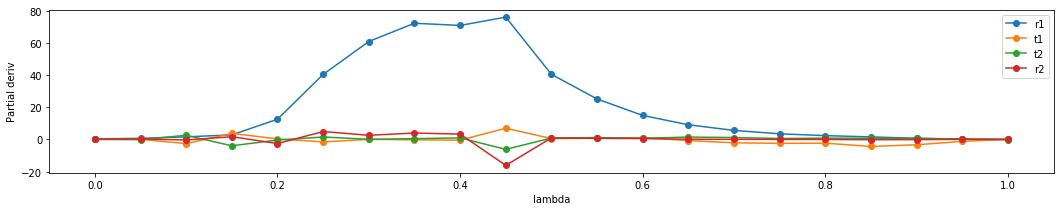

[7. 0. 0. 7.]
[7.   0.05 0.   7.  ]
[6.65  0.375 0.35  6.65 ]
[6.65  0.325 0.35  6.65 ]
[6.3   0.725 0.7   6.3  ]
[6.3   0.675 0.7   6.3  ]
[5.95  1.075 1.05  5.95 ]
[5.95  1.025 1.05  5.95 ]
[5.6   1.425 1.4   5.6  ]
[5.6   1.375 1.4   5.6  ]
[5.25  1.775 1.75  5.25 ]
[5.25  1.725 1.75  5.25 ]
[4.9   2.125 2.1   4.9  ]
[4.9   2.075 2.1   4.9  ]
[4.55  2.475 2.45  4.55 ]
[4.55  2.425 2.45  4.55 ]
[4.2   2.825 2.8   4.2  ]
[4.2   2.775 2.8   4.2  ]
[3.85  3.175 3.15  3.85 ]
[3.85  3.125 3.15  3.85 ]
[3.5   3.525 3.5   3.5  ]
[3.5   3.475 3.5   3.5  ]
[3.15  3.875 3.85  3.15 ]
[3.15  3.825 3.85  3.15 ]
[2.8   4.225 4.2   2.8  ]
[2.8   4.175 4.2   2.8  ]
[2.45  4.575 4.55  2.45 ]
[2.45  4.525 4.55  2.45 ]
[2.1   4.925 4.9   2.1  ]
[2.1   4.875 4.9   2.1  ]
[1.75  5.275 5.25  1.75 ]
[1.75  5.225 5.25  1.75 ]
[1.4   5.625 5.6   1.4  ]
[1.4   5.575 5.6   1.4  ]
[1.05  5.975 5.95  1.05 ]
[1.05  5.925 5.95  1.05 ]
[0.7   6.325 6.3   0.7  ]
[0.7   6.275 6.3   0.7  ]
[0.35  6.675 6.65  0.35 ]
[0

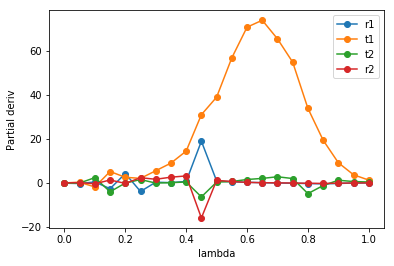

[7. 0. 0. 7.]
[7.   0.   0.05 7.  ]
[6.65  0.35  0.375 6.65 ]
[6.65  0.35  0.325 6.65 ]
[6.3   0.7   0.725 6.3  ]
[6.3   0.7   0.675 6.3  ]
[5.95  1.05  1.075 5.95 ]
[5.95  1.05  1.025 5.95 ]
[5.6   1.4   1.425 5.6  ]
[5.6   1.4   1.375 5.6  ]
[5.25  1.75  1.775 5.25 ]
[5.25  1.75  1.725 5.25 ]
[4.9   2.1   2.125 4.9  ]
[4.9   2.1   2.075 4.9  ]
[4.55  2.45  2.475 4.55 ]
[4.55  2.45  2.425 4.55 ]
[4.2   2.8   2.825 4.2  ]
[4.2   2.8   2.775 4.2  ]
[3.85  3.15  3.175 3.85 ]
[3.85  3.15  3.125 3.85 ]
[3.5   3.5   3.525 3.5  ]
[3.5   3.5   3.475 3.5  ]
[3.15  3.85  3.875 3.15 ]
[3.15  3.85  3.825 3.15 ]
[2.8   4.2   4.225 2.8  ]
[2.8   4.2   4.175 2.8  ]
[2.45  4.55  4.575 2.45 ]
[2.45  4.55  4.525 2.45 ]
[2.1   4.9   4.925 2.1  ]
[2.1   4.9   4.875 2.1  ]
[1.75  5.25  5.275 1.75 ]
[1.75  5.25  5.225 1.75 ]
[1.4   5.6   5.625 1.4  ]
[1.4   5.6   5.575 1.4  ]
[1.05  5.95  5.975 1.05 ]
[1.05  5.95  5.925 1.05 ]
[0.7   6.3   6.325 0.7  ]
[0.7   6.3   6.275 0.7  ]
[0.35  6.65  6.675 0.35 ]
[0

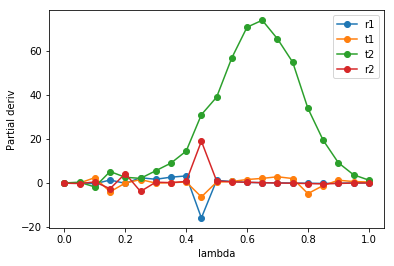

[7.    0.    0.    7.025]
[7.    0.    0.    6.975]
[6.65  0.35  0.35  6.675]
[6.65  0.35  0.35  6.625]
[6.3   0.7   0.7   6.325]
[6.3   0.7   0.7   6.275]
[5.95  1.05  1.05  5.975]
[5.95  1.05  1.05  5.925]
[5.6   1.4   1.4   5.625]
[5.6   1.4   1.4   5.575]
[5.25  1.75  1.75  5.275]
[5.25  1.75  1.75  5.225]
[4.9   2.1   2.1   4.925]
[4.9   2.1   2.1   4.875]
[4.55  2.45  2.45  4.575]
[4.55  2.45  2.45  4.525]
[4.2   2.8   2.8   4.225]
[4.2   2.8   2.8   4.175]
[3.85  3.15  3.15  3.875]
[3.85  3.15  3.15  3.825]
[3.5   3.5   3.5   3.525]
[3.5   3.5   3.5   3.475]
[3.15  3.85  3.85  3.175]
[3.15  3.85  3.85  3.125]
[2.8   4.2   4.2   2.825]
[2.8   4.2   4.2   2.775]
[2.45  4.55  4.55  2.475]
[2.45  4.55  4.55  2.425]
[2.1   4.9   4.9   2.125]
[2.1   4.9   4.9   2.075]
[1.75  5.25  5.25  1.775]
[1.75  5.25  5.25  1.725]
[1.4   5.6   5.6   1.425]
[1.4   5.6   5.6   1.375]
[1.05  5.95  5.95  1.075]
[1.05  5.95  5.95  1.025]
[0.7   6.3   6.3   0.725]
[0.7   6.3   6.3   0.675]
[0.35  6.65 

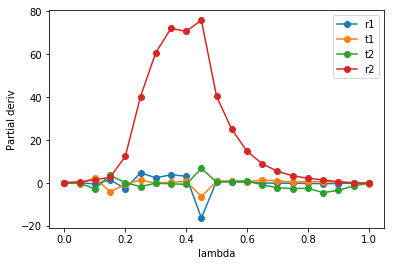

In [136]:
def test_partials():
    refdist, targetdist = 5, 1.5
    pseudo = np.array((7, 0, 0, 7))
    deltaZ = np.array((-7., 7., 7., -7.))
    z1, z2, zsuper = 7, 7, []
    zs = np.linspace(-6, 6, 1000)
    zs = np.array([-refdist*horton.angstrom/2, -targetdist*horton.angstrom/2, targetdist*horton.angstrom/2, refdist*horton.angstrom/2])
    xs = zs * 0
    gridpoints = np.vstack((xs, xs, zs)).T.copy()
    
    for site in range(4):
        plt.figure(figsize=(18,3))
        derivs = []
        lvals = np.linspace(0, 1, 21)
        for lval in lvals:
            derivs.append(get_partial_derivative(refdist, targetdist, pseudo + lval*deltaZ, z1, z2, zsuper, gridpoints, site))
        derivs = np.array(derivs)
        for pidx, pos in enumerate('r1 t1 t2 r2'.split()):
            plt.plot(lvals, derivs[:, pidx], 'o-', label=pos)
        plt.legend()
        plt.ylabel('Partial deriv')
        plt.xlabel('lambda')
        plt.show()
        
test_partials()

[7.025 0.    0.    7.   ]
[6.975 0.    0.    7.   ]
[6.325 0.7   0.7   6.3  ]
[6.275 0.7   0.7   6.3  ]
[5.625 1.4   1.4   5.6  ]
[5.575 1.4   1.4   5.6  ]
[4.925 2.1   2.1   4.9  ]
[4.875 2.1   2.1   4.9  ]
[4.225 2.8   2.8   4.2  ]
[4.175 2.8   2.8   4.2  ]
[3.525 3.5   3.5   3.5  ]
[3.475 3.5   3.5   3.5  ]
[2.825 4.2   4.2   2.8  ]
[2.775 4.2   4.2   2.8  ]
[2.125 4.9   4.9   2.1  ]
[2.075 4.9   4.9   2.1  ]
[1.425 5.6   5.6   1.4  ]
[1.375 5.6   5.6   1.4  ]
[0.725 6.3   6.3   0.7  ]
[0.675 6.3   6.3   0.7  ]
[0. 7. 7. 0.]
[0.05 7.   7.   0.  ]
[7. 0. 0. 7.]
[7.   0.05 0.   7.  ]
[6.3   0.725 0.7   6.3  ]
[6.3   0.675 0.7   6.3  ]
[5.6   1.425 1.4   5.6  ]
[5.6   1.375 1.4   5.6  ]
[4.9   2.125 2.1   4.9  ]
[4.9   2.075 2.1   4.9  ]
[4.2   2.825 2.8   4.2  ]
[4.2   2.775 2.8   4.2  ]
[3.5   3.525 3.5   3.5  ]
[3.5   3.475 3.5   3.5  ]
[2.8   4.225 4.2   2.8  ]
[2.8   4.175 4.2   2.8  ]
[2.1   4.925 4.9   2.1  ]
[2.1   4.875 4.9   2.1  ]
[1.4   5.625 5.6   1.4  ]
[1.4   5.575 5.6  

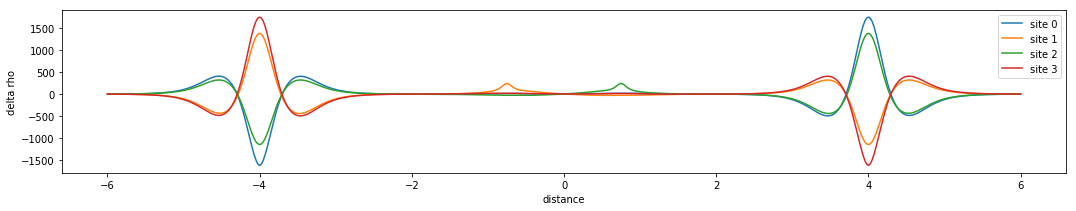

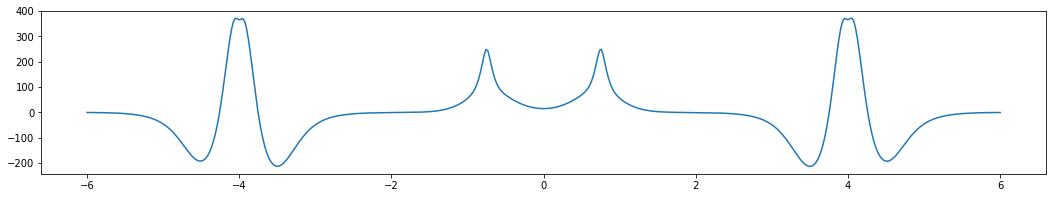

In [224]:
def test_integrated_partials():
    refdist, targetdist = 8., 1.5
    pseudo = np.array((7, 0, 0, 7))
    deltaZ = np.array((-7., 7., 7., -7.))
    z1, z2, zsuper = 7, 7, []
    #zs = np.linspace(-4, 4, 1000)*horton.angstrom
    #zs = np.array([-refdist*horton.angstrom/2, -targetdist*horton.angstrom/2, targetdist*horton.angstrom/2, refdist*horton.angstrom/2])
    #xs = zs * 0
    #gridpoints = np.vstack((xs, xs, zs)).T.copy()
    
    xs = np.linspace(-5, 5, 100)*horton.angstrom
    ys = np.linspace(-5, 5, 100)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 500)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    zs = np.array(sorted(set(grid[:, 2])))
    
    plt.figure(figsize=(18,3))
    finals = []
    for site in range(4):
        derivs = []
        lvals = np.linspace(0, 1, 11)
        actual_lvals = []
        for lval in lvals:
            try:
                derivs.append(get_partial_derivative(refdist, targetdist, pseudo + lval*deltaZ, z1, z2, zsuper, grid, site))
                actual_lvals.append(lval)
            except horton.NoSCFConvergence:
                print ('Skipped')
                pass
        derivs = np.array(derivs)
        intvals = np.trapz(derivs, actual_lvals, axis=0)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(intvals[grid[:, 2] == zcoord]))
        rho_final = deltaZ[site]*np.array(proj)
        finals.append(rho_final)
        plt.plot(zs/horton.angstrom, rho_final, label='site %d' % site)
    plt.legend()
    plt.ylabel('delta rho')
    plt.xlabel('distance')
    plt.show()
    plt.figure(figsize=(18,3))
    plt.plot(zs/horton.angstrom, np.sum(np.array(finals), axis=0), label='site %d' % site)
test_integrated_partials()

[7. 0. 0. 7.]
[0. 7. 7. 0.]


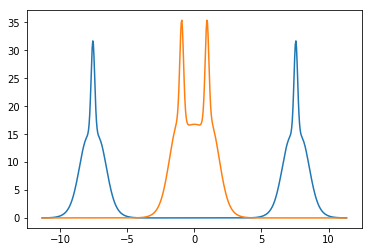

In [225]:
def test_initial_final():
    refdist, targetdist = 8., 1.
    pseudo = np.array((7, 0, 0, 7))
    deltaZ = np.array((-7., 7., 7., -7.))
    z1, z2, zsuper = 7, 7, []
    #zs = np.linspace(-4, 4, 1000)*horton.angstrom
    #xs = zs * 0
    #gridpoints = np.vstack((xs, xs, zs)).T.copy()
    xs = np.linspace(-5, 5, 50)*horton.angstrom
    ys = np.linspace(-5, 5, 50)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 500)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    zs = sorted(set(grid[:, 2]))
    
    initial = do_run(refdist, targetdist, pseudo + 0*deltaZ, z1, z2, zsuper, grid)
    final = do_run(refdist, targetdist, pseudo + 1*deltaZ, z1, z2, zsuper, grid)
    
    # project
    proj = []
    
    for zcoord in zs:
        proj.append(np.sum(initial[grid[:, 2] == zcoord]))
    rho_initial = np.array(proj)
    proj = []
    for zcoord in zs:
        proj.append(np.sum(final[grid[:, 2] == zcoord]))
    rho_final = np.array(proj)
    
    
    plt.plot(zs, rho_initial)
    plt.plot(zs, rho_final)
test_initial_final()
    

In [42]:
def trace_derivative(refdist, targetdist, z1, z2):
    horton.log.set_level(0)
    # build grid
    xs = np.linspace(-2, 2, 10)*horton.angstrom
    ys = np.linspace(-2, 2, 10)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 200)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    
    delta = 0.05
    basepoints = np.linspace(0, 1, 5)
    derivs = [[], [], [], []]
    for lval in basepoints:
        pseudo_base = np.array((z1*(1-lval), z1*lval, z2*lval, z2*(1-lval)))
        
        for atom in (0, 1, 2, 3):
            pseudo = pseudo_base.copy()
            pseudo[atom] += delta/2
            rho_up = do_run(refdist, targetdist, pseudo, z1, z2, [], grid) 
            pseudo[atom] -= delta
            if pseudo[atom] < 0:
                # switch to fwd FD
                rho_dn = do_run(refdist, targetdist, pseudo_base, z1, z2, [], grid)
                deriv = (rho_up-rho_dn)/(delta/2)
            else:
                rho_dn = do_run(refdist, targetdist, pseudo, z1, z2, [], grid)
                deriv = (rho_up-rho_dn)/delta
            derivs[atom].append(deriv)
    
    initial = do_run(refdist, targetdist, (z1, 0, 0, z2), z1, z2, [], grid)
    final = do_run(refdist, targetdist, (0, z1, z2, 0), z1, z2, [], grid)
    
    return grid, zs, basepoints, derivs, initial, final
grid, zs, basepoints, derivs, initial, final = trace_derivative(10, 1.5, 7, 7)

[7.025 0.    0.    7.   ]
[6.975 0.    0.    7.   ]
[7.    0.025 0.    7.   ]
[7. 0. 0. 7.]
[7.    0.    0.025 7.   ]
[7. 0. 0. 7.]
[7.    0.    0.    7.025]
[7.    0.    0.    6.975]
[5.275 1.75  1.75  5.25 ]
[5.225 1.75  1.75  5.25 ]
[5.25  1.775 1.75  5.25 ]
[5.25  1.725 1.75  5.25 ]
[5.25  1.75  1.775 5.25 ]
[5.25  1.75  1.725 5.25 ]
[5.25  1.75  1.75  5.275]
[5.25  1.75  1.75  5.225]
[3.525 3.5   3.5   3.5  ]
[3.475 3.5   3.5   3.5  ]
[3.5   3.525 3.5   3.5  ]
[3.5   3.475 3.5   3.5  ]
[3.5   3.5   3.525 3.5  ]
[3.5   3.5   3.475 3.5  ]
[3.5   3.5   3.5   3.525]
[3.5   3.5   3.5   3.475]
[1.775 5.25  5.25  1.75 ]
[1.725 5.25  5.25  1.75 ]
[1.75  5.275 5.25  1.75 ]
[1.75  5.225 5.25  1.75 ]
[1.75  5.25  5.275 1.75 ]
[1.75  5.25  5.225 1.75 ]
[1.75  5.25  5.25  1.775]
[1.75  5.25  5.25  1.725]
[0.025 7.    7.    0.   ]
[0. 7. 7. 0.]
[0.    7.025 7.    0.   ]
[0.    6.975 7.    0.   ]
[0.    7.    7.025 0.   ]
[0.    7.    6.975 0.   ]
[0.    7.    7.    0.025]
[0. 7. 7. 0.]
(7, 0, 0

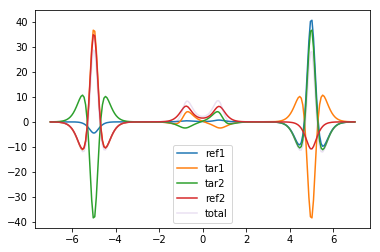

In [44]:
def visualise(grid, zs, basepoints, derivs, inital, final):
    #plt.figure(dpi=400)
    labels = 'ref1 tar1 tar2 ref2'.split()
    deltaZ = (-7, 7, 7, -7)
    total = None
    for atom in range(4):
        rho = np.trapz(np.array(derivs[atom]).T, basepoints, axis=1)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        proj = np.array(proj) * deltaZ[atom]
        if total is None:
            total = np.array(proj)
        else:
            total += np.array(proj)
        plt.plot(zs/horton.angstrom, proj, label=labels[atom])
    plt.plot(zs/horton.angstrom, total, label='total', alpha=0.2)
    plt.legend()
visualise(grid, zs, basepoints, derivs, initial, final)

(108.96021457942567, 51.04095744076579)
(4, 200)


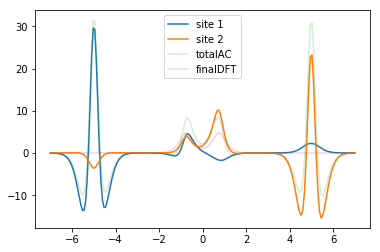

In [45]:
def visualise_combined(grid, zs, basepoints, derivs, inital, final):
    #plt.figure(dpi=400)
    deltaZ = (-7, 7, 7, -7)
    components = []
    for atom in range(4):
        rho = np.trapz(np.array(derivs[atom]).T, basepoints, axis=1)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        proj = np.array(proj) * deltaZ[atom]
        components.append(proj)
    components = np.array(components)
    
    # i, f
    proj = []
    for zcoord in zs:
        proj.append(np.sum(initial[grid[:, 2] == zcoord]))
    rho_initial = np.array(proj)
    proj = []
    for zcoord in zs:
        proj.append(np.sum(final[grid[:, 2] == zcoord]))
    rho_final = np.array(proj)
    print (np.sum(rho_initial), np.sum(components))
    print (components.shape)
    
    assigned1 = rho_initial.copy()
    assigned1[len(assigned1)/2:] = 0
    assigned2 = rho_initial.copy()
    assigned2[:len(assigned2)/2] = 0
    plt.plot(zs/horton.angstrom, np.sum(components[:2], axis=0) - assigned1, label='site 1')
    plt.plot(zs/horton.angstrom, np.sum(components[2:], axis=0) - assigned2, label='site 2')
    plt.plot(zs/horton.angstrom, np.sum(components, axis=0)+rho_initial, label='totalAC', alpha=0.2)
    plt.plot(zs/horton.angstrom, rho_final, label='finalDFT', alpha=0.2)
    plt.legend()
visualise_combined(grid, zs, basepoints, derivs, initial, final)

Problem might be in the many different calculations and the numerical stability thereof. Next try: separate into two different paths $\mu$ and $\varphi$ (one for each atom):
$$\rho_t = \int_r^t d\lambda \partial_\lambda\rho = \int_r^t d\lambda \sum_{i\in(\mu,\varphi)} \frac{\partial\rho}{\partial i}\frac{\partial i}{\partial\lambda}= \int_r^t d\lambda \sum_{i\in(\mu,\varphi)} \frac{\partial\rho}{\partial i}\left(\sum_{I\in i}\frac{\partial i}{\partial Z_I}\frac{\partial Z_I}{\partial\lambda}\right)$$

With $Z_I^+ = 7\mu\Leftrightarrow \mu = Z_I^+/7$ and $Z_I^- = 7(1-\mu)\Leftrightarrow \mu = 1- Z_I^-/7$, $\partial_{Z_I^+}\mu = 1/7$ and $\partial_{Z_I^-}\mu = -1/7$. On the other hand, $\partial_\lambda Z_I^+ = \Delta Z_I^+=7$, similar for $Z_I^-$.

Therefore
$$\rho_t =\int_r^t d\lambda \sum_{i\in(\mu,\varphi)} \frac{\partial\rho}{\partial i}\left(\sum_{I\in i}\frac{\partial i}{\partial Z_I}\frac{\partial Z_I}{\partial\lambda}\right)
=2\sum_{i\in(\mu,\varphi)} \int_r^t d\lambda \frac{\partial\rho}{\partial i}$$

In [10]:
def trace_derivative(refdist, targetdist, z1, z2):
    horton.log.set_level(0)
    # build grid
    xs = np.linspace(-2, 2, 10)*horton.angstrom
    ys = np.linspace(-2, 2, 10)*horton.angstrom
    zs = np.linspace(-refdist/2-2, refdist/2+2, 200)*horton.angstrom
    grid = np.column_stack(map(np.ndarray.ravel, np.meshgrid(xs, ys, zs)))
    
    delta = 0.05
    basepoints = np.linspace(0, 1, 3)
    derivs = [[], [], [], []]
    sign = (-1, 1, 1, -1)
    for lval in basepoints:
        pseudo_base = np.array((z1*(1-lval), z1*lval, z2*lval, z2*(1-lval)))
        
        for group in (0, 1):
            central = True
            pseudo = pseudo_base.copy()
            pseudo[group*2] += sign[group*2]*delta/2
            pseudo[group*2+1] += sign[group*2+1]*delta/2
            if pseudo[group*2] < 0 or pseudo[group*2+1] < 0:
                rho_up = do_run(refdist, targetdist, pseudo_base, z1, z2, [], grid)
                central = False
            else:
                rho_up = do_run(refdist, targetdist, pseudo, z1, z2, [], grid) 
            pseudo[group*2] -= sign[group*2]*delta
            pseudo[group*2+1] -= sign[group*2+1]*delta
            
            if pseudo[group*2] < 0 or pseudo[group*2+1] < 0:
                # switch to fwd FD
                rho_dn = do_run(refdist, targetdist, pseudo_base, z1, z2, [], grid)
                central = False
            else:
                rho_dn = do_run(refdist, targetdist, pseudo, z1, z2, [], grid)
            if central:
                deriv = (rho_up-rho_dn)/delta
            else:
                deriv = (rho_up-rho_dn)/(delta/2)
            derivs[group].append(deriv)
    
    initial = do_run(refdist, targetdist, (z1, 0, 0, z2), z1, z2, [], grid)
    final = do_run(refdist, targetdist, (0, z1, z2, 0), z1, z2, [], grid)
    
    return grid, zs, basepoints, derivs, initial, final
grid, zs, basepoints, derivs, initial, final = trace_derivative(10, 1.5, 7, 7)

[6.975 0.025 0.    7.   ]
[7. 0. 0. 7.]
[7.    0.    0.025 6.975]
[7. 0. 0. 7.]
[3.475 3.525 3.5   3.5  ]
[3.525 3.475 3.5   3.5  ]
[3.5   3.5   3.525 3.475]
[3.5   3.5   3.475 3.525]
[0. 7. 7. 0.]
[0.025 6.975 7.    0.   ]
[0. 7. 7. 0.]
[0.    7.    6.975 0.025]
(7, 0, 0, 7)
(0, 7, 7, 0)


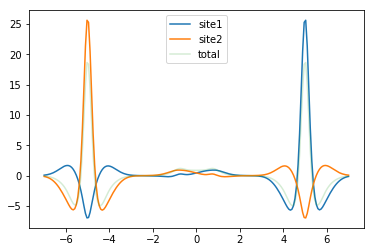

In [11]:
def visualise(grid, zs, basepoints, derivs, inital, final):
    #plt.figure(dpi=400)
    labels = 'site1 site2'.split()
    total = None
    for atom in range(2):
        rho = np.trapz(np.array(derivs[atom]).T, basepoints, axis=1)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        proj = np.array(proj) 
        if total is None:
            total = np.array(proj)
        else:
            total += np.array(proj)
        plt.plot(zs/horton.angstrom, proj, label=labels[atom])
    plt.plot(zs/horton.angstrom, total, label='total', alpha=0.2)
    plt.legend()
visualise(grid, zs, basepoints, derivs, initial, final)

(108.64060333905931, 33.63387916293061)
(2, 200)


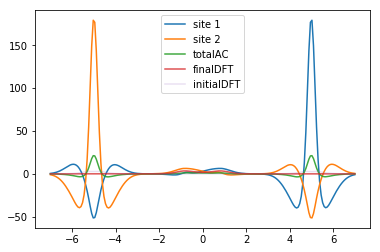

In [12]:
def visualise_combined(grid, zs, basepoints, derivs, inital, final):
    #plt.figure(dpi=400)
    components = []
    for atom in range(2):
        rho = np.trapz(np.array(derivs[atom]).T, basepoints, axis=1)
        proj = []
        for zcoord in zs:
            proj.append(np.sum(rho[grid[:, 2] == zcoord]))
        proj = np.array(proj) 
        components.append(proj)
    components = np.array(components)
    
    # i, f
    proj = []
    for zcoord in zs:
        proj.append(np.sum(initial[grid[:, 2] == zcoord]))
    rho_initial = np.array(proj)
    proj = []
    for zcoord in zs:
        proj.append(np.sum(final[grid[:, 2] == zcoord]))
    rho_final = np.array(proj)
    print (np.sum(rho_initial), np.sum(components))
    print (components.shape)
    
    assigned1 = rho_initial.copy()
    assigned1[len(assigned1)/2:] = 0
    assigned2 = rho_initial.copy()
    assigned2[:len(assigned2)/2] = 0
    plt.plot(zs/horton.angstrom, 7*np.sum(components[:1], axis=0) - assigned1, label='site 1')
    plt.plot(zs/horton.angstrom, 7*np.sum(components[1:], axis=0) - assigned2, label='site 2')
    plt.plot(zs/horton.angstrom, np.sum(components, axis=0)+rho_initial, label='totalAC', alpha=0.9)
    plt.plot(zs/horton.angstrom, rho_final, label='finalDFT', alpha=0.8)
    plt.plot(zs/horton.angstrom, rho_initial, label='initialDFT', alpha=0.2)
    plt.legend()
visualise_combined(grid, zs, basepoints, derivs, initial, final)